In [148]:
%run setup.ipynb

In [11]:
import lmfit
from bisect import bisect_left, bisect_right

In [3]:
def exponential_peak(x, center, amplitude, decay, baseline, floor, ceiling):
    """Symmetric exponential peak function.

    Parameters
    ----------
    x : ndarray
        Independent variable.
    center : int or float
        The center of the peak.
    amplitude : float
        Amplitude parameter.
    decay : float
        Decay parameter.
    baseline : float
        Baseline parameter.
    floor : float
        Minimum value that the result can take.
    ceiling : float
        Maximum value that the result can take.

    Returns
    -------
    y : ndarray

    """

    # locate the index at which to split data into left and right flanks
    ix_split = bisect_right(x, center)

    # compute left flank
    xl = center - x[:ix_split]
    yl = baseline + amplitude * np.exp(-xl / decay)

    # compute right flank
    xr = x[ix_split:] - center
    yr = baseline + amplitude * np.exp(-xr / decay)

    # prepare output
    y = np.concatenate([yl, yr])

    # apply limits
    y = y.clip(floor, ceiling)

    return y


In [115]:
def tex_format_param(params, name):
    value = params[name].value
    stderr = params[name].stderr
    relerr = stderr * 100 / value
    return f"${name}={value:.3f}\\pm{stderr:.3f}$ $({relerr:.1f}\\%)$\n"


In [173]:
def analyse_exponential_peak_fit(pop, chromosome, center, flank, locus, ax=None):
    
    # load gwss data
    pwindows, gwindows, h1, h12, h123, h2_h1 = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)

    # locate center and region to fit
    loc_center = bisect_left(ppos, center)
    gcenter = gpos[loc_center]
    loc_region = slice(bisect_left(gpos, gcenter - flank), 
                       bisect_right(gpos, gcenter + flank))
    
    # setup data to fit
    x = gpos[loc_region]
    y = h12[loc_region]

    # fit peak model
    peak_model = lmfit.Model(exponential_peak)
    peak_params = lmfit.Parameters()
    peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
    peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.15, max=3.0)
    peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    peak_result = peak_model.fit(y, x=x, params=peak_params)

    # fit null model
    null_model = lmfit.models.ConstantModel()
    null_params = lmfit.Parameters()
    null_params['c'] = lmfit.Parameter('c', vary=True, value=0.03, min=0, max=1)
    null_result = null_model.fit(y, x=x, params=null_params)

    # plot
    if ax is None:
        fig, ax = plt.subplots(facecolor='w', figsize=(8, 3))
    peak_result.plot_fit(
        ax=ax, 
        xlabel=f'Chromosome {chromosome} position (cM)', 
        ylabel='H12',
        data_kws=dict(markersize=2), 
        fit_kws=dict(color='k', linestyle='--')
    )
    ax.annotate(
        f'Model: exponential peak\n' +
        f'\nFit statistics:\n' + 
        f'$AIC={peak_result.aic:.0f}$\n' +
        f'$BIC={peak_result.bic:.0f}$\n' +
        f'$\\chi^{2}={peak_result.chisqr:.3f}$\n' +
        f'$\\Delta_{{i}}={null_result.aic - peak_result.aic:.0f}$\n' +
        f'\nVariables:\n' +
        tex_format_param(peak_result.params, 'amplitude') +
        tex_format_param(peak_result.params, 'decay') +
        tex_format_param(peak_result.params, 'baseline') +
        tex_format_param(peak_result.params, 'center')[:-1],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(10, -10), textcoords='offset points',
        va='top', ha='left', fontsize=8,
    )
    ax.set_title(f"{tex_math_species(pop_defs[pop]['label'])}; ${locus}$")
    
    fig_path = here() / 'artwork/expfit_{}'


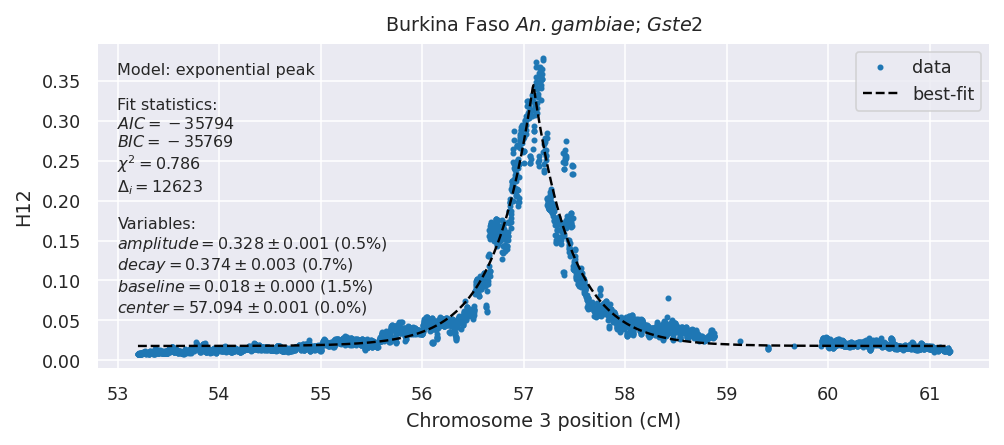

In [174]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=4, 
                             locus=gste2.Name)

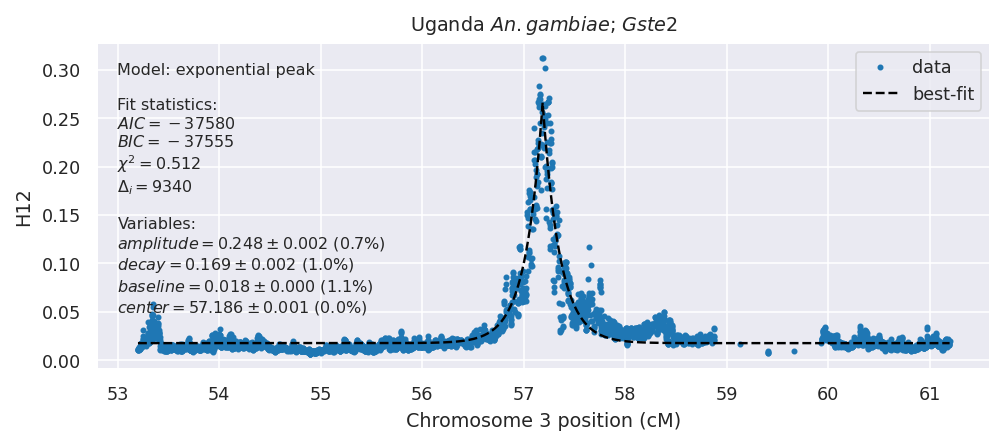

In [171]:
analyse_exponential_peak_fit('ug_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=4, 
                             locus=gste2.Name)

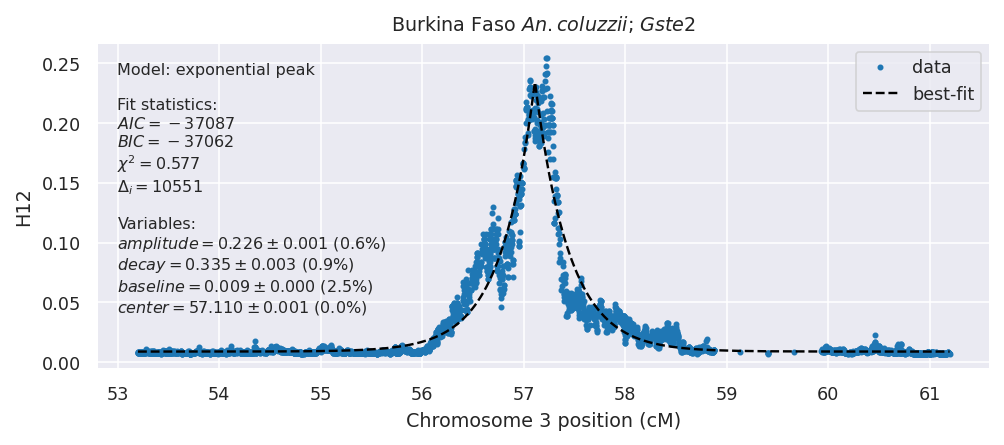

In [172]:
analyse_exponential_peak_fit('bf_col', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=4, 
                             locus=gste2.Name)

In [111]:
peak_result

In [109]:
peak_result.params['decay']

<Parameter 'decay', value=0.3379372001733023 +/- 0.00428, bounds=[0.15:3.0]>

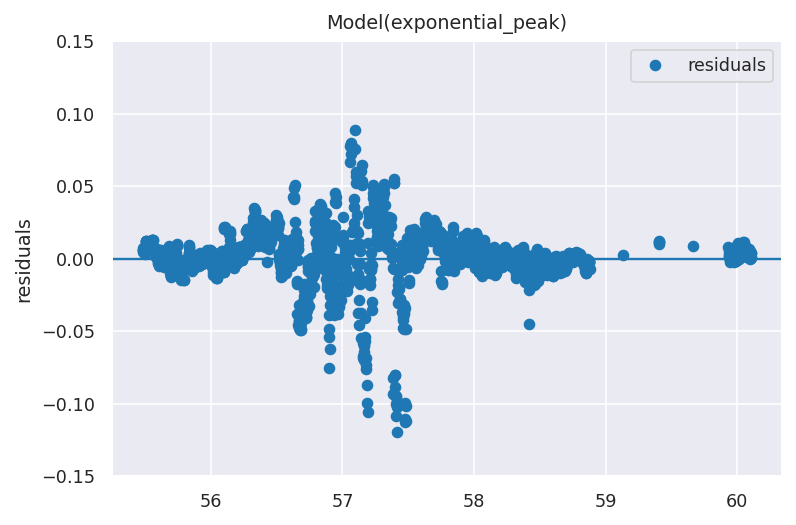

In [51]:
fig, ax = plt.subplots(facecolor='w')
peak_result.plot_residuals(ax=ax)
ax.set_ylim(-.15, .15);

In [57]:
print(peak_result.fit_report())

[[Model]]
    Model(exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 2000
    # variables        = 4
    chi-square         = 0.69800670
    reduced chi-square = 3.4970e-04
    Akaike info crit   = -15912.8581
    Bayesian info crit = -15890.4545
[[Variables]]
    center:     57.0936685 +/- 0.00153087 (0.00%) (init = 57.19733)
    amplitude:  0.32886715 +/- 0.00215367 (0.65%) (init = 0.5)
    decay:      0.33793720 +/- 0.00428300 (1.27%) (init = 0.5)
    baseline:   0.02621249 +/- 7.4176e-04 (2.83%) (init = 0.03)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)  = -0.718
    C(amplitude, decay) = -0.520


In [62]:
print(peak_result.ci_report())

              99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 center   :  -0.00470  -0.00470  -0.00209  57.09367  +0.00209  +0.00470  +0.00612
 amplitude:  -0.00638  -0.00426  -0.00213   0.32887  +0.00214  +0.00429  +0.00645
 decay    :  -0.01221  -0.00820  -0.00413   0.33794  +0.00420  +0.00847  +0.01282
 baseline :  -0.00222  -0.00147  -0.00073   0.02621  +0.00073  +0.00145  +0.00217


In [70]:
peak_result.params

name,value,standard error,relative error,initial value,min,max,vary
center,57.0936685,0.00153087,(0.00%),57.19733301545598,-inf,inf,True
amplitude,0.32886715,0.00215367,(0.65%),0.5,0.00000000,1.00000000,True
decay,0.33793720,0.00428300,(1.27%),0.5,0.15000000,3.00000000,True
baseline,0.02621249,7.4176e-04,(2.83%),0.03,0.00000000,1.00000000,True
ceiling,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
floor,0.00000000,0.00000000,,0,-inf,inf,False
